In [1]:
import os
import numpy as np
import pandas as pd
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.distributions as distributions
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import quakeFunctions as q

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.norm = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.norm(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
input_sz = 60
output_sz = 1

net = Net(input_size=input_sz, output_size=output_sz)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [7]:
train_set, test_set = q.getMotionSenseData()
x, y_target = q.get_tensors(train_set) 

--> Building Training and Test Datasets...
----> Data subjects information is imported.
--> Shape of Training Time-Series: (1082373, 19)
--> Shape of Test Time-Series: (331419, 19)
Shape of data:  torch.Size([216473, 60])
Shape of labels:  (216473, 1)


In [8]:
input_sz = x.shape[1]
output_sz = y_target.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
net = net.to(device)
y_target = y_target.to(device)
losses = []

Using device: cpu


Final loss:  0.59635925


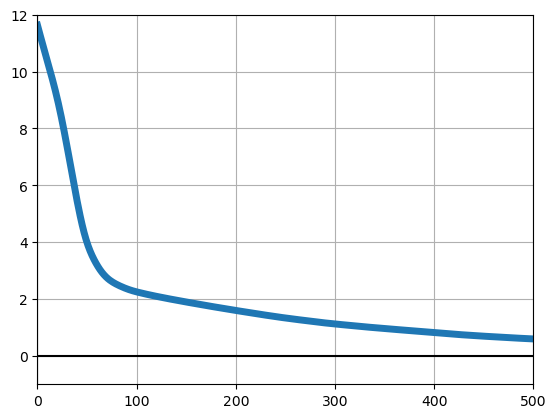

In [9]:
for _ in range(500):
    x = x.to(device)
    y = net(x)
    loss = loss_fn(y, y_target)
    losses.append(loss.detach().cpu().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Final loss: ", losses[-1])
q.plot(range(500), losses, xlim=(0, 500))

Shape of data:  torch.Size([66281, 60])
Shape of labels:  (66281, 1)
Final train loss ( 500  epochs):  0.27049658
Val loss ( 500  epochs):  0.6367346
Final val loss:  0.6367346


ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

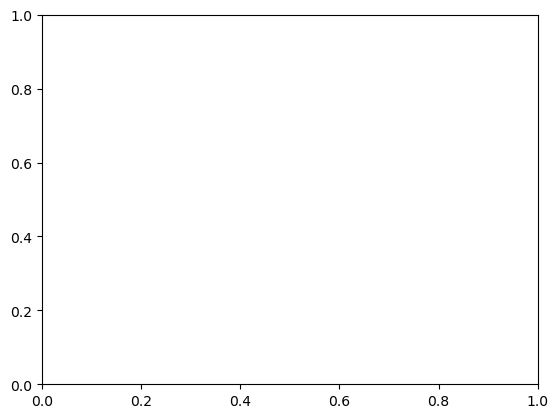

In [11]:
# validation / inference
x_test, y_test = q.get_tensors(test_set) 
val_losses, train_losses = [], []
for sz in [500]:
    for _ in range(sz):
        x = x.to(device)
        y = net(x)
        loss = loss_fn(y, y_target)
        losses.append(loss.detach().cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Final train loss (", sz, " epochs): ", losses[-1])
    train_losses.append(losses[-1])
    val_losses.append(loss_fn(net(x_test), y_test).detach().cpu().numpy())
    print("Val loss (", sz, " epochs): ", val_losses[-1])
print("Final val loss: ", val_losses[-1])
q.plot(range(7), train_losses, xlim=(0, 7))
q.plot(range(7), val_losses, xlim=(0, 7))